## 微调
使用在其他大数据集上训练好的模型，以此为基础，在自己的数据集上训练

神经网络可以分成两块：特征提取、Softmax回归

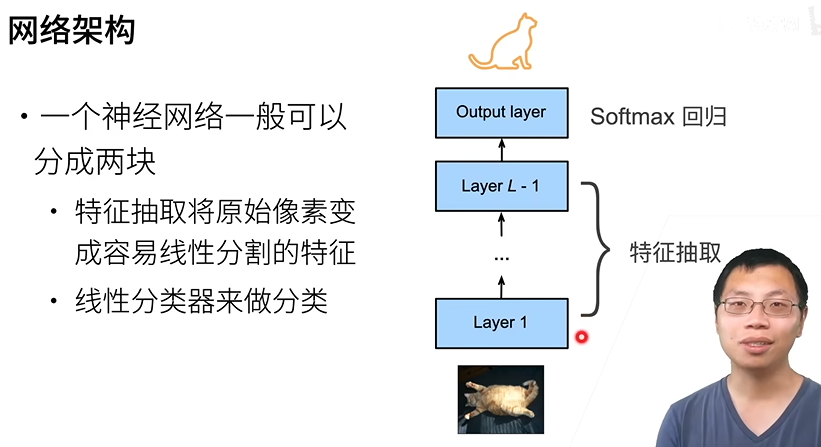

特征提取模块可以继续利用，肯定比随机的好

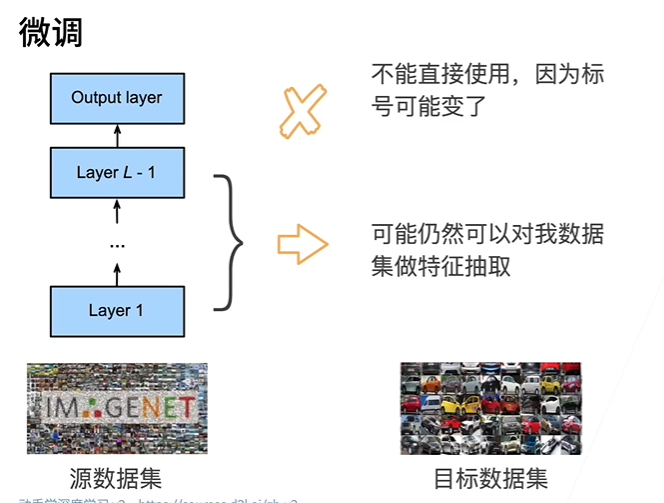

两个模型的架构必须一样才能copy其特征提取模块
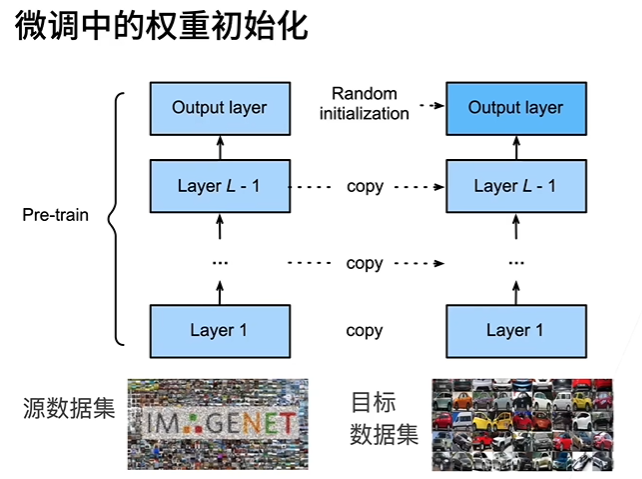

在pre-train的模型上使用更强的正则化，这样微调的效果比较好
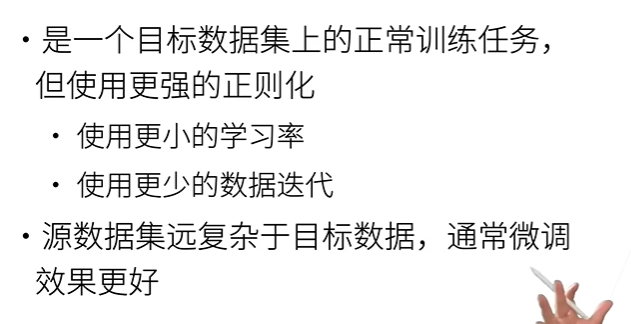

## 常用微调技巧 

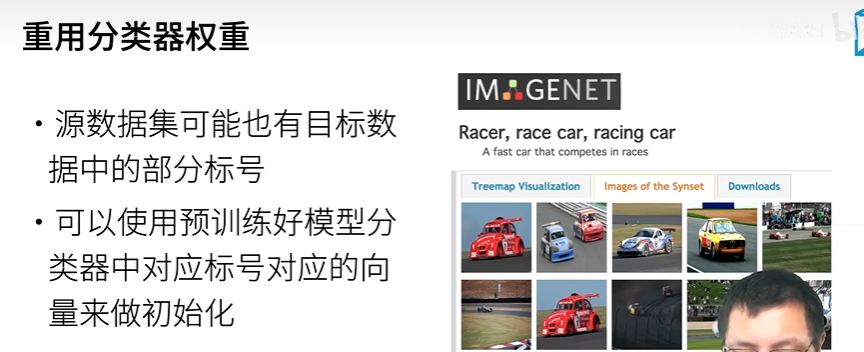
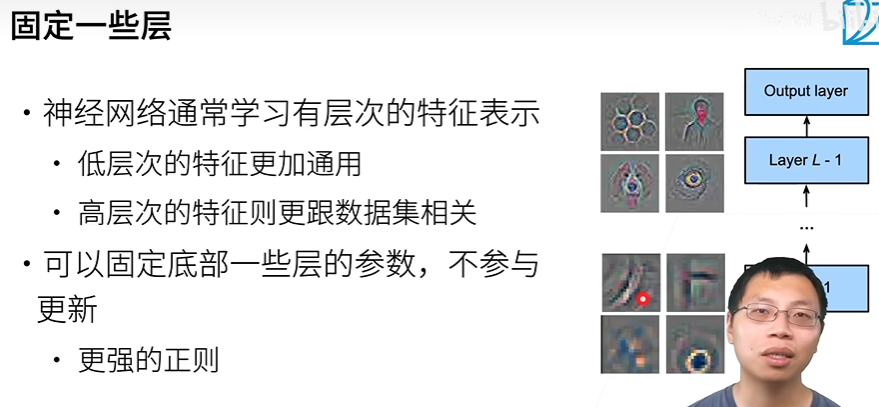

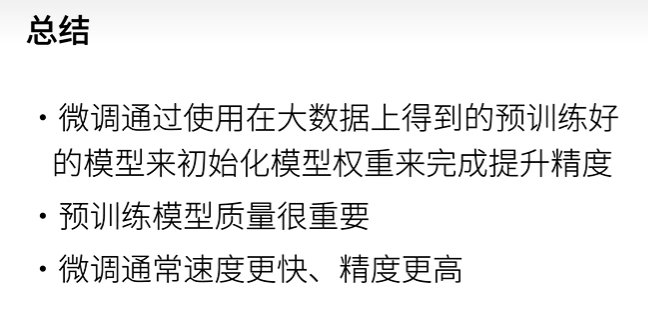

#### 需要将预训练的模型最后的全连接层进行修改
#### 最后一层的学习率调很大，其余层用默认的比较低的学习率

## 微调案例演示：热狗识别

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
# 下载数据集
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

读取训练和测试数据集中的所有图像文件

In [4]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train')) # 路径写到类别文件夹的上一级
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

In [7]:
train_imgs.class_to_idx

{'hotdog': 0, 'not-hotdog': 1}

ImageFolder加载数据集的格式如下

In [11]:
train_imgs[0][0], train_imgs[0][1] # train_imgs[i][0]是图片类型，train_imgs[i][1]是图片对应的类别索引

(<PIL.Image.Image image mode=RGB size=122x144>, 0)

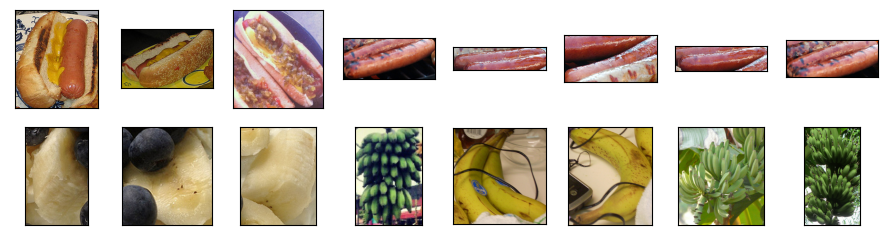

In [5]:
hotdogs = [train_imgs[i][0] for i in range(8)] 
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

定义图片增广

In [17]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], # 三个通道各自的均值
    [0.229, 0.224, 0.225]) # 三个通道各自的标准差

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

定义并初始化预训练好的模型

In [12]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\85370/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


如下所示，预训练模型的全连接层需要修改

In [13]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

开始定义微调的模型，修改输出层

In [8]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) # 根据数据集的类别数修改
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [15]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    """训练一个pre-train的模型"""
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    
    loss = nn.CrossEntropyLoss(reduction="none")
    
    if param_group:
        # 输出层使用较大学习率更新全连接层的参数
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        # 使用字典列表的形式，对不同层设置不同的学习率
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
        
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.303, train acc 0.896, test acc 0.941
225.2 examples/sec on [device(type='cuda', index=0)]


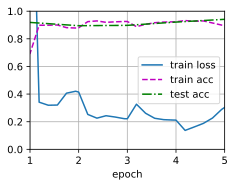

In [18]:
train_fine_tuning(finetune_net, 5e-5)

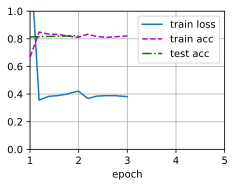

In [ ]:
scratch_net = torchvision.models.resnet18() # 没有使用预训练的参数
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)